In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import math

import time

from matplotlib import cm

import matplotlib.lines as mlines

%matplotlib inline

### Air Pollution Monitoring Data

In [4]:
df = pd.read_csv('EDF_Data.csv', header = 1)
df['TimePeriod'] = 'Jun2015-May2016'
df.tail()


,Longitude,Latitude,NO Value,NO2 Value,BC Value,TimePeriod
21483,-122.034943,37.560076,129.999995,44.778220,3.923761,Jun2015-May2016
21484,-122.034724,37.560164,60.799998,39.027545,1.408693,Jun2015-May2016
21485,-122.034681,37.559830,34.622951,28.816797,2.659885,Jun2015-May2016
21486,-122.034504,37.559958,74.764705,35.735434,1.776353,Jun2015-May2016
21487,-122.034503,37.559957,78.754782,41.062757,2.014664,Jun2015-May2016


In [5]:
df.shape

(21488, 6)

In [6]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

### Split the dataset into BC and NO2 since we are interested only in those two pollutants

In [7]:
BC_df = df[['Longitude', 'Latitude', 'BC Value', 'TimePeriod']]

In [8]:
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

### Reading Facility Level Data

In [9]:
# Read data for Oakland and drop duplicate facility ids
oak_facility = pd.read_csv('Data/oakland_facility_2017.csv', header = 0)
# Display all columns in the dataframe
oak_facility.columns

Index(['Unnamed: 0', 'county', 'eis facility id', 'agency facility id',
       'tri facility id', 'company name', 'site name', 'facility source type',
       'site latitude', 'site longitude', 'address', 'city', 'zip code',
       'pollutant code', 'pollutant type(s)', 'total emissions',
       'emissions uom', 'data set'],
      dtype='object')

In [10]:
# Drop columns that are not needed 
oak_facility.drop(columns = ['agency facility id', 'tri facility id','pollutant type(s)', 'data set',
                             'site name', 'address','Unnamed: 0', 'county'], inplace=True)

In [11]:
# Rename site latitude and site longitude column to just latitude and logitude
oak_facility.rename(columns={"site latitude": "latitude", "site longitude": "longitude", 'facility source type':'source-category'}, inplace=True)

In [12]:
# Display all columns in the dataframe
oak_facility.columns

Index(['eis facility id', 'company name', 'source-category', 'latitude',
       'longitude', 'city', 'zip code', 'pollutant code', 'total emissions',
       'emissions uom'],
      dtype='object')

In [13]:
# Filter the dataframe further for sources/facilities only in Oakland and neighbouring cities like San Leandro, Piedmont, Alameda and Berkeley
oak_facility = oak_facility[(oak_facility['city'] == 'OAKLAND') | (oak_facility['city'] == 'SAN LEANDRO') | (oak_facility['city'] == 'BERKELEY')|
                           (oak_facility['city'] == 'ALAMEDA') | (oak_facility['city'] == 'PIEDMONT')]

In [14]:
### First clean up source-category column
oak_facility['source-category'] = oak_facility['source-category'].replace({'Institutional (school, hospital, prison, etc.)':'Institution', 'Breweries/Distilleries/Wineries':'Breweries-Distilleries-Wineries'})
oak_facility.replace(' ', '-',regex=True,inplace=True)
oak_facility.replace(',', '-',regex=True,inplace=True)
oak_facility.replace('---', '-',regex=True,inplace=True)
oak_facility.replace('--', '-',regex=True,inplace=True)
oak_facility.replace(np.nan, 'Unknown', regex= True, inplace=True)

In [15]:
## Creating a separate dataframe for PM/Black carbon
Oak_PM10_25 = oak_facility[oak_facility['pollutant code'] != 'NOX']

In [16]:
PM10_pri = Oak_PM10_25[Oak_PM10_25['pollutant code']=='PM10-PRI']

In [17]:
## Drop PM10-PRI rows in Oak_PM dataframe
Oak_PM25  = Oak_PM10_25[Oak_PM10_25['pollutant code'] == 'PM25-PRI']

In [18]:
Facility_PM = pd.merge(Oak_PM25, PM10_pri, left_on ='eis facility id', right_on ='eis facility id', how='inner')


In [19]:
Facility_PM

,eis facility id,company name_x,source-category_x,latitude_x,longitude_x,city_x,zip code_x,pollutant code_x,total emissions_x,emissions uom_x,company name_y,source-category_y,latitude_y,longitude_y,city_y,zip code_y,pollutant code_y,total emissions_y,emissions uom_y
0,126911,PACIFIC-BELL,Unknown,37.766850,-122.249720,ALAMEDA,94501,PM25-PRI,0.000731,TON,PACIFIC-BELL,Unknown,37.766850,-122.249720,ALAMEDA,94501,PM10-PRI,0.000749,TON
1,127111,PACIFIC-BELL,Unknown,37.867710,-122.267840,BERKELEY,94704,PM25-PRI,0.002173,TON,PACIFIC-BELL,Unknown,37.867710,-122.267840,BERKELEY,94704,PM10-PRI,0.002226,TON
2,127511,PACIFIC-BELL,Unknown,37.806030,-122.269460,OAKLAND,94612,PM25-PRI,0.008291,TON,PACIFIC-BELL,Unknown,37.806030,-122.269460,OAKLAND,94612,PM10-PRI,0.008494,TON
3,127611,PACIFIC-BELL,Unknown,37.784220,-122.222410,OAKLAND,94601,PM25-PRI,0.000706,TON,PACIFIC-BELL,Unknown,37.784220,-122.222410,OAKLAND,94601,PM10-PRI,0.000724,TON
4,127711,PACIFIC-BELL,Unknown,37.833360,-122.263070,OAKLAND,94609,PM25-PRI,0.001554,TON,PACIFIC-BELL,Unknown,37.833360,-122.263070,OAKLAND,94609,PM10-PRI,0.001592,TON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,18778911,Unknown,Unknown,37.712960,-122.188680,SAN-LEANDRO,94577,PM25-PRI,22.124544,TON,Unknown,Unknown,37.712960,-122.188680,SAN-LEANDRO,94577,PM10-PRI,22.971518,TON
358,18779811,Unknown,Unknown,37.707820,-122.185500,SAN-LEANDRO,94577,PM25-PRI,0.000015,TON,Unknown,Unknown,37.707820,-122.185500,SAN-LEANDRO,94577,PM10-PRI,0.000015,TON
359,18781211,Unknown,Unknown,37.812106,-122.186447,OAKLAND,94621,PM25-PRI,0.000061,TON,Unknown,Unknown,37.812106,-122.186447,OAKLAND,94621,PM10-PRI,0.000061,TON
360,18782611,Unknown,Unknown,37.759959,-122.207782,OAKLAND,94621,PM25-PRI,0.992654,TON,Unknown,Unknown,37.759959,-122.207782,OAKLAND,94621,PM10-PRI,1.030213,TON


In [20]:
Facility_PM.drop(columns = ['zip code_x','pollutant code_x', 'emissions uom_x','company name_y','latitude_y','longitude_y',
                      'city_y','zip code_y','pollutant code_y','emissions uom_x', 'source-category_y'], inplace=True)

In [21]:
# Rename columns to meaningful names
Facility_PM.rename(columns={"latitude_x": "latitude", "longitude_x": "longitude", "city_x": "city", 
                       "total emissions_x" : "PM25", "total emissions_y": "PM10", "emissions uom_y": "units", 
                           "source-category_x":"source-category", "company name_x":"company"}, inplace=True)

In [22]:
Facility_PM.head()

,eis facility id,company,source-category,latitude,longitude,city,PM25,PM10,units
0,126911,PACIFIC-BELL,Unknown,37.76685,-122.24972,ALAMEDA,0.000731,0.000749,TON
1,127111,PACIFIC-BELL,Unknown,37.86771,-122.26784,BERKELEY,0.002173,0.002226,TON
2,127511,PACIFIC-BELL,Unknown,37.80603,-122.26946,OAKLAND,0.008291,0.008494,TON
3,127611,PACIFIC-BELL,Unknown,37.78422,-122.22241,OAKLAND,0.000706,0.000724,TON
4,127711,PACIFIC-BELL,Unknown,37.83336,-122.26307,OAKLAND,0.001554,0.001592,TON


In [23]:
Facility_PM.shape

(362, 9)

## TRAFFIC DATA

In [25]:
### Load Annual Average Daily Traffic (AADT) file from Caltrans
traffic = pd.read_csv('Data/Traffic_Oakland_AADT.csv', header = 0)

In [26]:
# Drop columns that are unneccessary and choose only Ahead_AADT, along with N/E latitude and longitude
traffic.drop(columns = ['OBJECTID','District','Route','County', 'Postmile', 
                        'Back_pk_h', 'Back_pk_m', 'Ahead_pk_h', 'Ahead_pk_m','Back_AADT','Lat_S_or_W', 'Lon_S_or_W'], inplace=True)

In [27]:
traffic.rename(columns={"Ahead_AADT":"AADT", "Lat_N_or_E":"Latitude", "Lon_N_or_E":"Longitude", "Descriptn":"Description"}, inplace=True)

In [28]:
traffic.head()

,Description,AADT,Latitude,Longitude
0,"ALAMEDA, BROADWAY/ ENCINAL AVENUE",8700,37.760576,-122.240708
1,"ALAMEDA, CENTRAL AVENUE/ SHERMAN STREET",9500,37.770910,-122.263477
2,JCT. RTE. 260 NORTH,0,37.771459,-122.276894
3,"OAKLAND, JCT. RTE. 880",22900,37.769397,-122.221166
4,"OAKLAND, EAST 12TH STREET",16400,37.772068,-122.217378


In [29]:
# Taking a closer look at the traffic data, there are some intersections where the AADT is zero, or the latitude and longitude are zero. We want to drop these rows
traffic = traffic[(traffic['Longitude']<-1) & (traffic['AADT']>1)]

In [30]:
traffic.shape

(71, 4)

### Creating dataframes using GeoPandas



In [31]:
# Create a geopandas dataframe with traffic data
geometry_traffic = [Point(xy) for xy in zip(traffic['Longitude'], traffic['Latitude'])]
geo_df_traffic = gpd.GeoDataFrame(traffic, crs = crs, geometry = geometry_traffic)

In [32]:
# Create a list of x and y coordinates for the PM facility data in Oakland using geopandas
geometry_facility_PM = [Point(xy) for xy in zip(Facility_PM['longitude'], Facility_PM['latitude'])]
geo_df_facility_PM = gpd.GeoDataFrame(Facility_PM, crs = crs, geometry = geometry_facility_PM)

In [33]:
# Create a list of x and y coordinates for the Black Carbon concentration data using geopandas
geometry_df_BC = [Point(xy) for xy in zip(BC_df['Longitude'], BC_df['Latitude'])]
geo_df_BC = gpd.GeoDataFrame(BC_df, crs = crs, geometry = geometry_df_BC)

### Find Closest Facility and Traffic Intersection to each point in the EDF data

In [34]:
#### Unary Union of the geo_df geometry - Closest Facility

pts = geo_df_facility_PM.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_facility_PM.geometry == nearest_points(point, pts)[1]
     return geo_df_facility_PM[nearest]['eis facility id'].to_numpy()[0]
geo_df_BC['Nearest_Facility'] = geo_df_BC.apply(lambda row: near(row.geometry), axis=1)

In [35]:
#### Unary Union of the geo_df geometry - Closest Traffic Intersection

pts = geo_df_traffic.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_traffic.geometry == nearest_points(point, pts)[1]
     return geo_df_traffic[nearest]['Description'].to_numpy()[0]
geo_df_BC['Nearest_Traffic'] = geo_df_BC.apply(lambda row: near(row.geometry), axis=1)

In [38]:
#### Merge df_BC with Oak_PM on Facility ID
df_BC_merge = pd.merge(left=BC_df, right=Facility_PM, left_on='Nearest_Facility', right_on='eis facility id')

In [39]:
#### Merge above dataframe with traffic
df_BC_merge_traffic = pd.merge(left=df_BC_merge, right=traffic, left_on='Nearest_Traffic', right_on='Description')

In [40]:
# Rename columns
df_BC_merge_traffic.rename(columns={'Latitude_x':'Latitude_Conc','Longitude_x':'Longitude_Conc','latitude':'Latitude_Fac','longitude':'Longitude_Fac','Latitude_y':'Latitude_Traf','Longitude_y':'Longitude_Traf'}, inplace=True)

In [41]:
#### Create an empty list call dist which stores all the distances between each point (facility and traffic)
dist_fac = []
dist_traf = []

In [42]:
### Defining a function to calculate the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [43]:
for row in df_BC_merge_traffic.iterrows():
    dist_fac.append(distance((row[1]['Latitude_Conc'], row[1]['Longitude_Conc']), (row[1]['Latitude_Fac'], row[1]['Longitude_Fac'])))
    dist_traf.append(distance((row[1]['Latitude_Conc'], row[1]['Longitude_Conc']), (row[1]['Latitude_Traf'], row[1]['Longitude_Traf'])))

In [44]:
df_BC_merge_traffic['Dist_Facility_mi'] = np.array(dist_fac)*0.621
df_BC_merge_traffic['Dist_Traffic_mi'] = np.array(dist_traf)*0.621

In [49]:
df_BC_merge_traffic.head()

,Longitude_Conc,Latitude_Conc,BC Value,TimePeriod,Conc_geo,Nearest_Facility,eis facility id,source-category,Latitude_Fac,Longitude_Fac,PM25,PM10,Fac_geo,AADT,Latitude_Traf,Longitude_Traf,Traf_geo,Dist_Facility_mi,Dist_Traffic_mi
0,-122.322594,37.806781,0.818032,Jun2015-May2016,POINT (-122.32259 37.80678),13747011,13747011,Unknown,37.80925,-122.31539,0.000225,0.00023,POINT (-122.31539 37.80925),278000,37.823843,-122.313766,POINT (-122.31377 37.82384),0.428407,1.272802
1,-122.322310,37.806150,0.551475,Jun2015-May2016,POINT (-122.32231 37.80615),13747011,13747011,Unknown,37.80925,-122.31539,0.000225,0.00023,POINT (-122.31539 37.80925),278000,37.823843,-122.313766,POINT (-122.31377 37.82384),0.433997,1.307623
2,-122.322301,37.806420,0.593712,Jun2015-May2016,POINT (-122.32230 37.80642),13747011,13747011,Unknown,37.80925,-122.31539,0.000225,0.00023,POINT (-122.31539 37.80925),278000,37.823843,-122.313766,POINT (-122.31377 37.82384),0.424656,1.290023
3,-122.322267,37.806689,0.739341,Jun2015-May2016,POINT (-122.32227 37.80669),13747011,13747011,Unknown,37.80925,-122.31539,0.000225,0.00023,POINT (-122.31539 37.80925),278000,37.823843,-122.313766,POINT (-122.31377 37.82384),0.414775,1.272057
4,-122.322262,37.806720,0.701457,Jun2015-May2016,POINT (-122.32226 37.80672),13747011,13747011,Unknown,37.80925,-122.31539,0.000225,0.00023,POINT (-122.31539 37.80925),278000,37.823843,-122.313766,POINT (-122.31377 37.82384),0.413605,1.269966


In [48]:
#### Drop columns from df_BC_merge that are not needed anymore
df_BC_merge_traffic.drop(columns = ['company','city','units', 'Description', 'Nearest_Traffic'], inplace=True)

In [46]:
#### Rename columns
df_BC_merge_traffic.rename(columns = {'geometry_x':'Conc_geo', 'geometry_y':'Fac_geo','geometry':'Traf_geo'}, inplace=True)

In [50]:
heatmap_df = df_BC_merge_traffic[['BC Value','Dist_Facility_mi','Dist_Traffic_mi']]

In [51]:
corr= heatmap_df.corr()

In [52]:
arr_corr = corr.as_matrix()

/home/shridhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


module://ipykernel.pylab.backend_inline


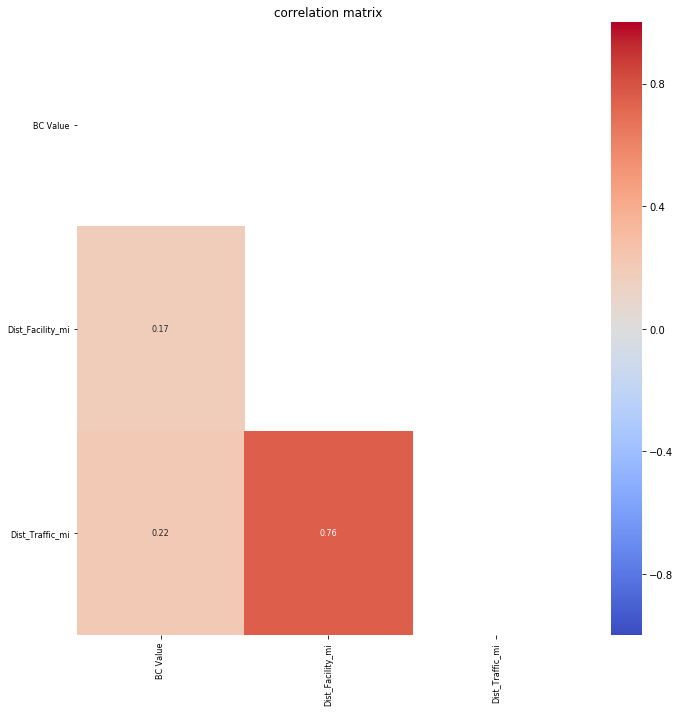

In [54]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
arr_corr[np.triu_indices_from(arr_corr)] = np.nan

fig, ax = plt.subplots(figsize=(10, 10))

hm = sns.heatmap(arr_corr, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr.index, rotation=360, fontsize=8)

ax.set_title('correlation matrix')
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)